In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# JAX
import jax.numpy as jnp
from jax import random, jit
import time

# RELOADING MODULES
import importlib

# UTILS DIRECTORY
import sys
import os
path_ = os.path.abspath(os.path.join('..', '00_utils'))

if path_ not in sys.path:
    sys.path.append(path_)

# processing
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

import nn_jax_diffrax
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

In [192]:
data = pd.read_csv('df_train.csv')

data_subsample = data[data.settlement_date >= '2010-01-01']
# data_subsample = data_subsample[data_subsample.settlement_date < '2010-01-09']
data_subsample = data_subsample[:400]
data_subsample.reset_index(drop=True, inplace=True)

data_subsample['settlement_date'] = pd.to_datetime(data_subsample['settlement_date'])
data_subsample.loc[:,'hour'] = data_subsample['settlement_date'].dt.hour

# select the main columns for the intial testing
data_subsample = data_subsample[['settlement_date', 'temperature', 'hour', 'nd']]

print(f"The first/ last time points in the subsample are {np.min(data_subsample.settlement_date)}/ {np.max(data_subsample.settlement_date)}")
print(f"Covering {np.max(data_subsample['settlement_date'].dt.day) - np.min(data_subsample['settlement_date'].dt.day)} days")

t = jnp.linspace(0., 1., data_subsample.shape[0]) 

# How many points cover one day?   
one_day_map = (data_subsample['settlement_date'].dt.day == np.min(data_subsample['settlement_date'].dt.day))
n_pt_per_day = one_day_map.sum()
print(f"Number of points per day: {n_pt_per_day}")

one_day_offset = (1/data_subsample.shape[0]) * n_pt_per_day
print(f"Time offset needed for 1 day: {one_day_offset}")

data_subsample.rename(columns={'settlement_date': 'date', 'temperature': 'var1', 'hour':'var2', 'nd':'y'}, inplace=True)
data_subsample['t'] = t

The first/ last time points in the subsample are 2010-01-01 00:00:00/ 2010-01-09 07:30:00
Covering 8 days
Number of points per day: 48
Time offset needed for 1 day: 0.12


In [193]:
def preprocessing(data_subsample, tau, m):
    """

    Args:
        data_subsample (dataframe): dataframe containing the subsample of the data;
        expected column names are: 'y', 'date', 'var1', 'var2' ect.
        tau (float): number of points per lag
        m (int): number of lags
    """
    d = data_subsample.copy()   
    columns = data_subsample.columns
    if 't' not in columns:
        raise ValueError("The time column is not present in the dataframe")
    if 'y' not in columns:
        raise ValueError("The target column is not present in the dataframe")
    
    t, y = data_subsample['t'], data_subsample['y']
    
    #----------------------------- SMOOTHING -----------------------------#
    # SIGMA = 2
    # y = gaussian_filter1d(y, sigma = SIGMA)
    # d['y'] = y
    
    #--------------------------------- LAGS -----------------------------#
    for i in range(1, m+1):
        d[f'y_lag{i}'] = d['y'].shift(tau*i)
            
    # the first point that has the last lag available
    first_index = d[f'y_lag{i}'].index[~d[f'y_lag{i}'].isna()][0]

    # drop rows where time lags are not available
    d = d.iloc[first_index:]
    t = d['t'] # reload 't' after slicing 
        
    split = int(0.5 * len(t)) # 50/50 split
    t_train, t_test = t[:split], t[split:]

    print(f"Training data: {t_train.shape[0]} timepoints")
    print(f"Training data: {t_test.shape[0]} timepoints")
    
    #------------------------- INTERPOLATION FUNCTIONS ---------------------------#

    var_cols_map = ['var' in col for col in d.columns]
    var_cols = d.columns[var_cols_map]
    
    # 1. fit interpolation functions 
    # 2. geneate data
    # 3. save to a new dataframe
    
    interpolated_data_train = {}
    interpolated_data_test = {}
    
    # INDEPENDENT VARIABLES
    for var in var_cols:
        cs = CubicSpline(t, d[var])
        interpolated_data_train[var] = cs(t_train)
        interpolated_data_test[var] = cs(t_test)
        
    # DEPENDENT VARIABLES    
    cs_y = CubicSpline(t, d['y'])
    interpolated_data_train['y'] = cs_y(t_train)
    interpolated_data_test['y'] = cs_y(t_test)
    
    # LAGGED DEPENDENT VARIABLES
    for i in range(1, m+1):
        cs = CubicSpline(t, d[f'y_lag{i}'])
        interpolated_data_train[f'y_lag{i}'] = cs(t_train)
        # here we need some logic to reuse the data available from the training set
        interpolated_data_test[f'y_lag{i}'] = cs(t_test)
        # this gives the whole range, but we need to cut it off where the training data ends
        offset = tau*i # points are needed for the lag
        for p in range(offset, len(t_test)):
            interpolated_data_test[f'y_lag{i}'][p] = np.nan
        
    # TIME
    interpolated_data_train['t'] = t_train
    interpolated_data_test['t'] = t_test

    print(f"Training data: {t_train.shape[0]} timepoints after interpolation")
    
    df_train = pd.DataFrame(interpolated_data_train)
    df_test = pd.DataFrame(interpolated_data_test)

    #------------------------- SCALE ---------------------------#
    scaler = StandardScaler()
    
    columns_to_scale = df_train.columns.difference(['t'])
    df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
    df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
    
    return df_train, df_test

In [194]:
def preprocessing_offsets(data_subsample, tau, m):
    """

    Args:
        data_subsample (dataframe): dataframe containing the subsample of the data;
        expected column names are: 'y', 'date', 'var1', 'var2' ect.
        tau (float): number of points per lag
        m (int): number of lags
    """
    d = data_subsample.copy()   
    columns = data_subsample.columns
    if 't' not in columns:
        raise ValueError("The time column is not present in the dataframe")
    if 'y' not in columns:
        raise ValueError("The target column is not present in the dataframe")
    
    t, y = data_subsample['t'], data_subsample['y']
    
    #----------------------------- SMOOTHING -----------------------------#
    # SIGMA = 2
    # y = gaussian_filter1d(y, sigma = SIGMA)
    # d['y'] = y
    
    #--------------------------------- LAGS -----------------------------#
    for i in range(1, m+1):
        d[f'y_lag{i}'] = d['y'].shift(tau*i)
            
    # the first point that has the last lag available
    first_index = d[f'y_lag{i}'].index[~d[f'y_lag{i}'].isna()][0]

    # drop rows where time lags are not available
    d = d.iloc[first_index:]
    t = d['t'] # reload 't' after slicing 
        
    split = int(0.5 * len(t)) # 50/50 split
    t_train, t_test = t[:split], t[split:]

    print(f"Training data: {t_train.shape[0]} timepoints")
    print(f"Training data: {t_test.shape[0]} timepoints")
    
    #------------------------- INTERPOLATION FUNCTIONS ---------------------------#

    var_cols_map = ['var' in col for col in d.columns]
    var_cols = d.columns[var_cols_map]
    
    # 1. fit interpolation functions 
    # 2. geneate data
    # 3. save to a new dataframe
    
    interpolated_data_train = {}
    interpolated_data_test = {}
    
    # INDEPENDENT VARIABLES
    for var in var_cols:
        cs = CubicSpline(t, d[var])
        interpolated_data_train[var] = cs(t_train)
        interpolated_data_test[var] = cs(t_test)
        
    # DEPENDENT VARIABLES    
    cs_y = CubicSpline(t, d['y'])
    interpolated_data_train['y'] = cs_y(t_train)
    interpolated_data_test['y'] = cs_y(t_test)
    
    # LAGGED DEPENDENT VARIABLES
    for i in range(1, m+1):
        cs = CubicSpline(t, d[f'y_lag{i}'])
        interpolated_data_train[f'y_lag{i}'] = cs(t_train)
        # here we need some logic to reuse the data available from the training set
        interpolated_data_test[f'y_lag{i}'] = cs(t_test)
        # this gives the whole range, but we need to cut it off where the training data ends
        offset = tau*i # points are needed for the lag
        for p in range(offset, len(t_test)):
            interpolated_data_test[f'y_lag{i}'][p] = np.nan
        
    # TIME
    interpolated_data_train['t'] = t_train
    interpolated_data_test['t'] = t_test

    print(f"Training data: {t_train.shape[0]} timepoints after interpolation")
    
    df_train = pd.DataFrame(interpolated_data_train)
    df_test = pd.DataFrame(interpolated_data_test)

    #------------------------- SCALE ---------------------------#
    scaler = StandardScaler()
    
    columns_to_scale = df_train.columns.difference(['t'])
    df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
    df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
    
    return df_train, df_test

In [219]:
df_train, df_test = preprocessing(data_subsample, 48, 2)

Training data: 152 timepoints
Training data: 152 timepoints
Training data: 152 timepoints after interpolation


In [220]:
df_train.head()

,var1,var2,y,y_lag1,y_lag2,t
96,1.895068,-1.545027,-0.988829,-0.857526,-0.215728,0.240602
97,1.343670,-1.545027,-1.024704,-0.880169,-0.176595,0.243108
98,0.792272,-1.404234,-1.110356,-0.950481,-0.234691,0.245614
99,0.726104,-1.404234,-1.237345,-1.065152,-0.403805,0.248120
100,0.659936,-1.263440,-1.318405,-1.137583,-0.575505,0.250627


In [221]:
df_train.to_csv('df_train_preprocessed.csv', index=False)

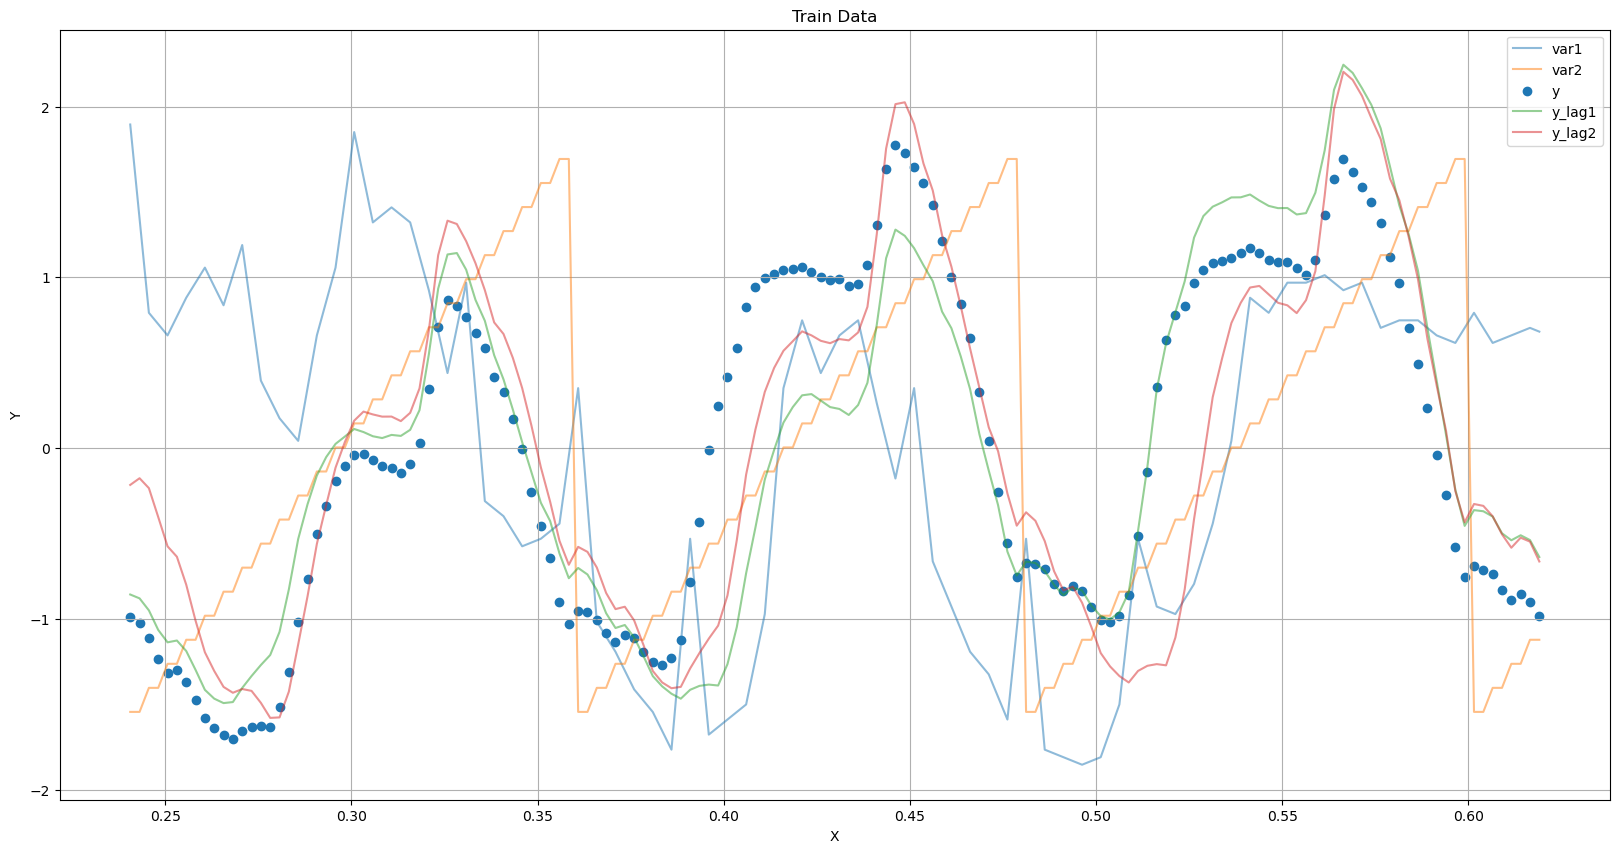

In [222]:
if True:
    plt.figure(figsize=(20, 10))
    
    for col in df_train.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train['t'], df_train[col], label=col, alpha=1)
            continue
        plt.plot(df_train['t'], df_train[col], '-', label=col, alpha=0.5)

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [227]:
df_train.drop(columns=['y', 't'])

,var1,var2,y_lag1,y_lag2
96,1.895068,-1.545027,-0.857526,-0.215728
97,1.343670,-1.545027,-0.880169,-0.176595
98,0.792272,-1.404234,-0.950481,-0.234691
99,0.726104,-1.404234,-1.065152,-0.403805
100,0.659936,-1.263440,-1.137583,-0.575505
...,...,...,...,...
243,0.637881,-1.404234,-0.498946,-0.504998
244,0.659936,-1.263440,-0.539862,-0.583608
245,0.681992,-1.263440,-0.510599,-0.524823
246,0.704048,-1.122646,-0.538671,-0.548095


In [233]:
import nn_jax_diffrax
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

layer_widths = [5, 100, 100, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)

ys = jnp.atleast_2d(jnp.array(df_train['y'])).T
ts = jnp.array(df_train['t'])
Xs = jnp.array(df_train.drop(columns=['y', 't']))
extra_args = (Xs, ts)
y0 = jnp.array([ys[0]])

for k in [int(len(ys)*0.1)]: # , int(len(ys)*0.1), len(ys)
    state = node_model.train(state, ts[:k] 
                            , ys[:k], y0
                            , num_epochs = 50000
                            , extra_args = extra_args[:k]
                            )

Epoch 100, Loss: 25.267057418823242
Epoch 200, Loss: 24.79766845703125
Epoch 300, Loss: 24.745845794677734
Epoch 400, Loss: 22.75288963317871
Epoch 500, Loss: 20.86354637145996
Epoch 600, Loss: 20.00381851196289
Epoch 700, Loss: 19.43634033203125
Epoch 800, Loss: 19.060792922973633
Epoch 900, Loss: 18.74298667907715
Epoch 1000, Loss: 18.427391052246094
Epoch 1100, Loss: 18.153615951538086
Epoch 1200, Loss: 17.917142868041992
Epoch 1300, Loss: 17.694120407104492
Epoch 1400, Loss: 17.511863708496094
Epoch 1500, Loss: 17.453210830688477
Epoch 1600, Loss: 17.298980712890625
Epoch 1700, Loss: 17.168466567993164
Epoch 1800, Loss: 17.195222854614258
Epoch 1900, Loss: 16.992353439331055
Epoch 2000, Loss: 16.968992233276367
Epoch 2100, Loss: 16.85381317138672
Epoch 2200, Loss: 16.822772979736328
Epoch 2300, Loss: 16.743228912353516
Epoch 2400, Loss: 16.69876480102539
Epoch 2500, Loss: 16.6893253326416
Epoch 2600, Loss: 16.63567352294922
Epoch 2700, Loss: 16.57942771911621
Epoch 2800, Loss: 16.5

In [234]:
# reload
import nn_jax_diffrax
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE
node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

#  def neural_ode(self, params, y0, t, state, extra_args=None): 
y_train_pred = node_model.neural_ode(state.params, y0, ts, state, extra_args)

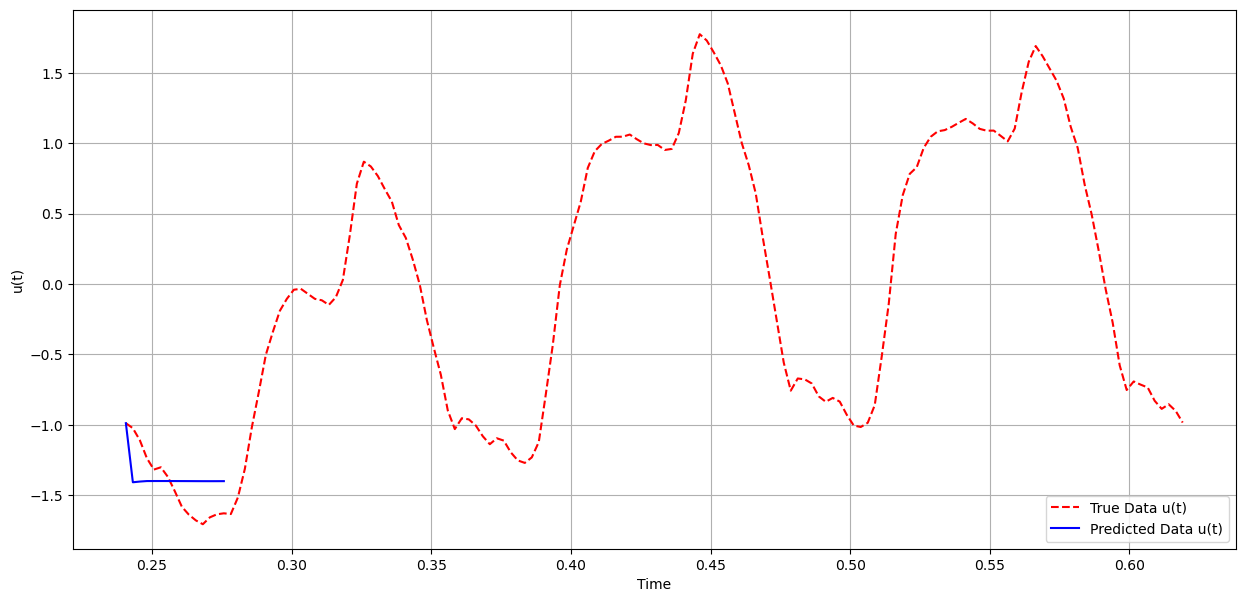

In [235]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'r--', label='True Data u(t)')  
plt.plot(ts[:k], np.squeeze(y_train_pred)[:k], 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### Does Pyomo model also fail to converge properly with this type of preprocessing?

In [206]:
import nn_pyomo
importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

layer_widths = [6, 30, 1]

tol = 1e-3
params = {"tol":1e-3, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 5, 
          # "hessian_approximation": 'limited-memory', 
          # "mu_strategy": 'adaptive', 
          # "check_derivatives_for_naninf": 'yes',
          # 'nlp_scaling_method' = 'gradient-based',
          # 'linear_solver'] = 'ma57',
          "max_iter": 500 }

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(ys), # y
                           np.array(ts), # t
                           np.array(Xs),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = np.array(ys), 
                           penalty_lambda_reg = 0.01, 
                           time_invariant = True,
                           extra_input = np.array(Xs), # X
                           w_init_method = 'xavier', 
                           params = params,
                           deriv_method="pyomo"
                           )

ode_model.build_model()
end_timer_build = time.time()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T 

Ipopt 3.14.16: tol=0.001
dual_inf_tol=0.001
compl_inf_tol=0.001
constr_viol_tol=0.001
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   145824
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   142790

Total number of variables............................:     1418
              

Mean Absolute Error - Direct: 0.09221913665533066
Mean Absolute Error - ODE solver: 22.319137573242188


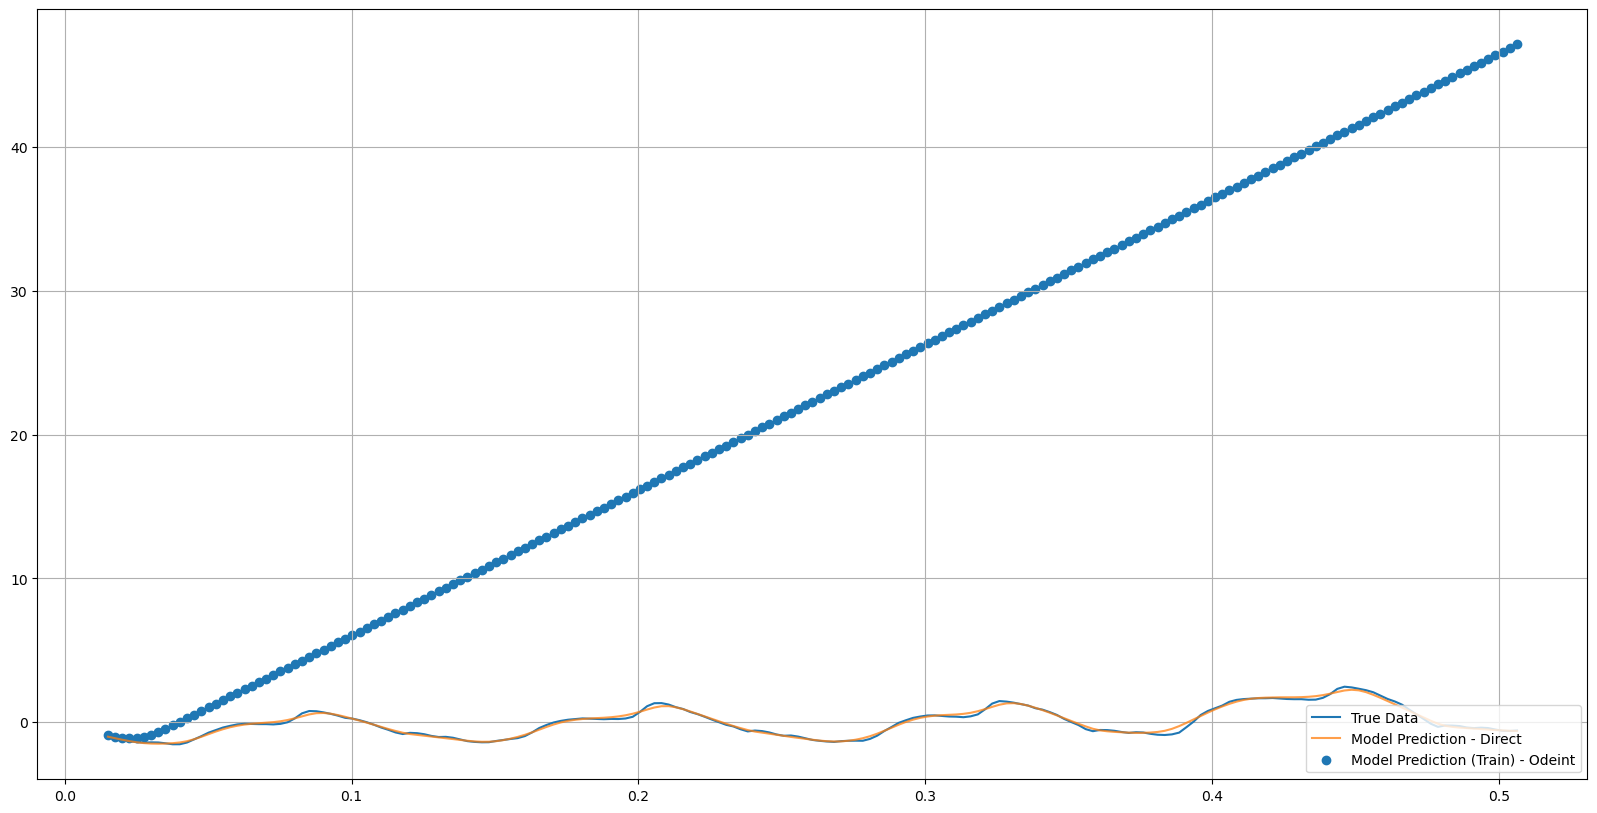

In [207]:
y0 = ys[0]
# step_1 = 150
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)

plt.plot(ts, u_model.T, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [208]:
trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

In [209]:
import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-4
params = {"tol":1e-4, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 300 }

initial_state = (u_model[0])
# Initialize the direct ODE solver
direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs), params=params)

# Build and solve the model
direct_solver.build_model()
solver_info = direct_solver.solve_model()

# Extract the solution
y_solution = direct_solver.extract_solution()
print(len(y_solution))


Ipopt 3.14.16: tol=0.0001
dual_inf_tol=0.0001
compl_inf_tol=0.0001
constr_viol_tol=0.0001
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=300


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     4118
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      589

Total number of variables............................:     1178
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       

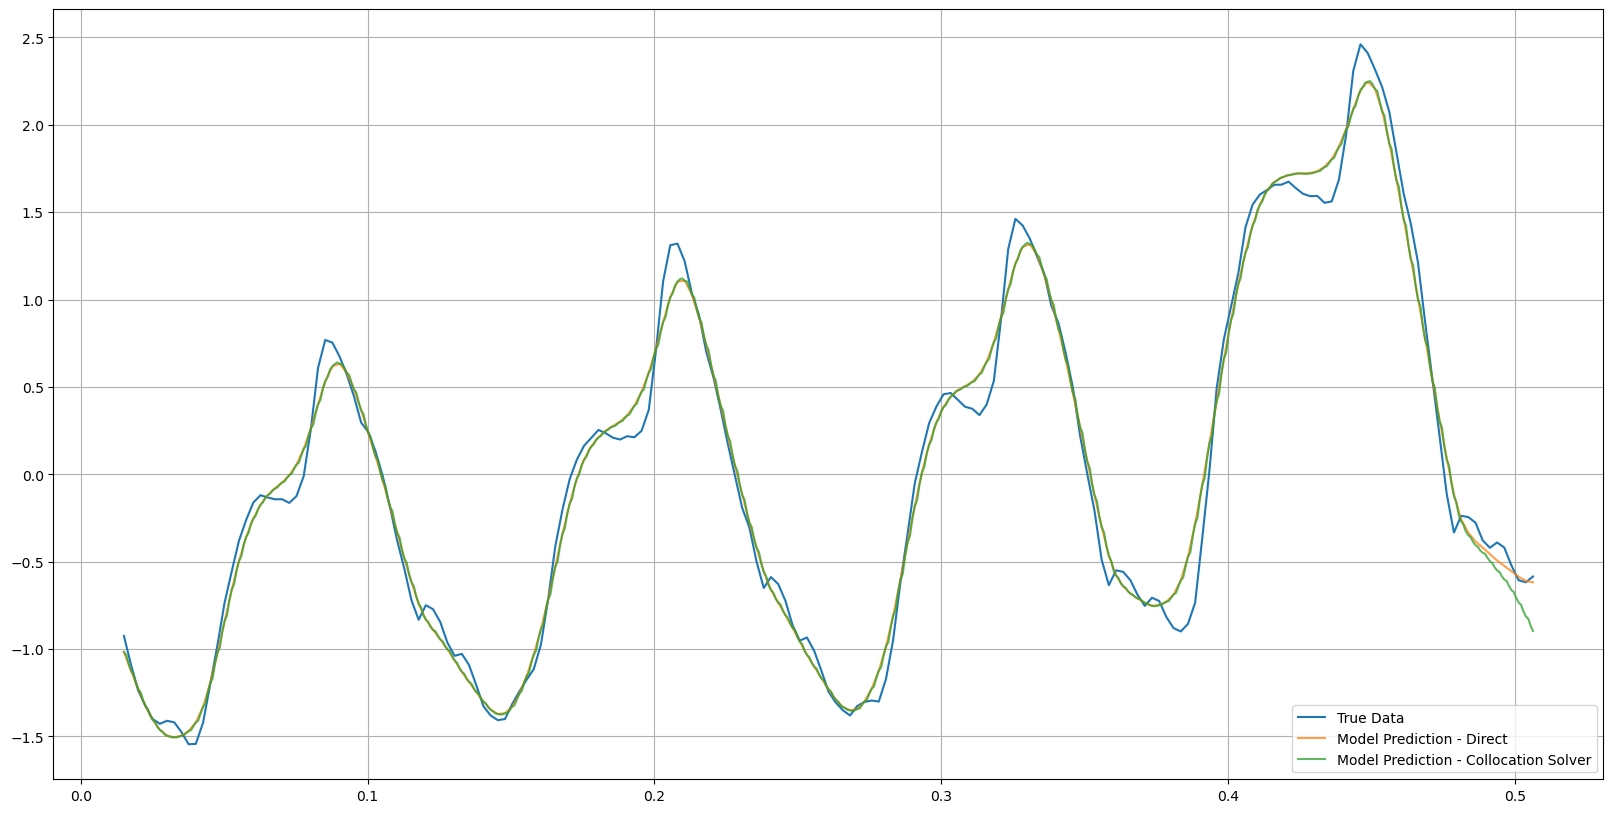

In [210]:
t_temp = np.linspace(min(ts), max(ts), len(y_solution))

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_temp, y_solution, label='Model Prediction - Collocation Solver', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()